In [221]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
import os
import shutil
import azureml
import cv2
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core.run import Run
import glob2 as glob
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
from zipfile import ZipFile

### Read the raw data depth file, parse it and  return data and image dimesnion and depthscale

In [14]:
#read raw data bytes from the depth file
def read_data(raw_data):
    with open(raw_data, 'rb') as file:
        line = str(file.readline())[2:-3]
        header = line.split("_")
        res = header[0].split("x")
        width = int(res[0])
        height = int(res[1])
        depthScale = float(header[1])
        maxConfidence = float(header[2])
        data = file.read()
        file.close()
    return data, width, height, depthScale

### generating the depth map from raw bytes

In [224]:
def parseDepth(tx, ty):
    depth = data[(int(ty) * width + int(tx)) * 3 + 0] << 8
    depth += data[(int(ty) * width + int(tx)) * 3 + 1]
    depth *= depthScale
    return depth

In [314]:
def prepare_depthmap(data, width, height, depthScale):
        # prepare array for output
    output = np.zeros((width, height, 1))
    for cx in range(width):
        for cy in range(height):
#             output[cx][height - cy - 1][0] = parseConfidence(cx, cy)
#             output[cx][height - cy - 1][1] = im_array[cy][cx][1] / 255.0 #test matching on RGB data
#             output[cx][height - cy - 1][2] = 1.0 - min(parseDepth(cx, cy) / 2.0, 1.0) #depth data scaled to be visible
            output[cx][height - cy - 1] = parseDepth(cx, cy) #depth data scaled to be visible
    return (np.array(output,dtype = 'float32').reshape(width,height), height, width)

In [315]:
data, width, height, depthScale = read_data('data')

In [316]:
depthmap,height, width = prepare_depthmap(data, width, height, depthScale)

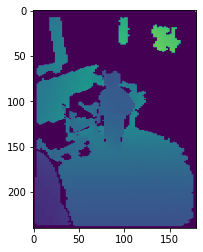

In [317]:
plt.imshow(depthmap)


### Read and parse the camera calibration file

In [236]:
#parse line of numbers
def parseNumbers(line):
    output = []
    values = line.split(" ")
    for value in values:
        output.append(float(value))
    return output

In [237]:
#parse calibration
with open('python_converter/input/camera_calibration.txt', 'r') as file:
    calibration = []
    print(file.readline()[:-1])
    calibration.append(parseNumbers(file.readline()))
    print(str(calibration[0]) + "\n") #color camera intrinsics - fx, fy, cx, cy
    print(file.readline()[:-1])
    calibration.append(parseNumbers(file.readline()))
    print(str(calibration[1]) + "\n") #depth camera intrinsics - fx, fy, cx, cy
    print(file.readline()[:-1])
    calibration.append(parseNumbers(file.readline()))
    print(str(calibration[2]) + "\n") #depth camera position relativelly to color camera in meters

Color camera intrinsic:
[0.7733313, 1.0311261, 0.4959453, 0.50100666]

Depth camera intrinsic:
[0.8438058, 1.1241881, 0.52709174, 0.5139793]

Depth camera position:
[-0.0108590545, 0.0023264, -0.0]



### Utility functions for depthmap to pointcloud conversion

In [238]:
#convert point into 3D
def convert2Dto3D(intrisics, x, y, z):
    cx = intrisics[2] * float(width)
    cy = intrisics[3] * float(height)
    fx = intrisics[0] * float(width)
    fy = intrisics[1] * float(height)
    tx = (x - cx) * z / fx
    ty = (y - cy) * z / fy
    output = []
    output.append(tx)
    output.append(ty)
    output.append(z)
    return output

In [239]:
def TOF2World(tx, ty):
    if tx > 1 and ty > 1 and tx < width - 2 and ty < height - 2:
        depth = parseDepth(tx, ty)
        if depth:
            return convert2Dto3D(calibration[1], tx, ty, depth)
    return 0

In [249]:
#write obj
with open('output.obj', 'w') as file:
    for x in range(width):
        for y in range(height):
            res = TOF2World(x, y)
            if res:
                file.write('v ' + str(res[0]) + ' ' + str(-res[2]) + ' ' + str(res[1]) + '\n')
    file.close()

In [250]:
from pyntcloud import PyntCloud
output = PyntCloud.from_file('output.obj')
# output.plot()
x= output.points['x']
y= output.points['y']
z= output.points['z']

### label measurement functionality using point clouds

In [589]:
import ipyvolume as ipv
from scipy.spatial import distance

fig = ipv.figure()
scatter = ipv.scatter(x, y, z)
ipv.selector_default()
coordinates = []
def height_info(*_):
    indices = scatter.selected[0]
    x_coord = np.min(scatter.x[indices])
    y_coord = np.min(scatter.y[indices])
    print('x_coordinate', x_coord)
    print('y_coordinate', y_coord)
    coordinates.append([x_coord,y_coord])
    if len(coordinates) == 2:
        print("execute the below cells for height calculation")
#     return coordinates
scatter.observe(height_info, 'selected')
ipv.show()

Output()

In [ ]:
#TODO: handle the null points selection errors. If the user selects the range point which have nulls inside it , it throws an error
#      please run the above cell again and try selecting again. 

In [294]:
def calculate_distance(coords):
    if len(coords) <2:
        print("Don't have enough coordinates fro predictions:")
    if len(coords) >2:
        print("Refresh the cell and please select the two coordiates: ")
    height_dist = distance.euclidean(coordinates[0], coordinates[1])
    height_dist = height_dist *100
    return height_dist

In [297]:
height = calculate_distance(coordinates)
print("The distance between selected point is: {} cm".format(height))

The distance between selected point is: 40.80829322338104 cm


## Using one of the models from dev environment for depth map prediction

In [ ]:
workspace = Workspace.from_config()
workspace

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

checkboxes = []

for experiment_name, experiment in workspace.experiments.items():
    checkbox = widgets.Checkbox(
        value=False,
        description=experiment_name
    )
    display(checkbox)
    checkboxes.append(checkbox)

In [ ]:
# Get the selected experiments.
selected_experiments = []
for checkbox in checkboxes:
    if checkbox.value == True:
        selected_experiments.append(checkbox.description)

# Get folder.
temp_path = "logs"
if os.path.exists(temp_path):
    shutil.rmtree(temp_path)
os.mkdir(temp_path)

# For each selected experiment download logs of all completed runs.
for selected_experiment in selected_experiments:
    print("Experiment: {}".format(selected_experiment))
    experiment = workspace.experiments.get(selected_experiment)
    for run_index, run in enumerate(list(experiment.get_runs())[::-1]):
        log_path = os.path.join(temp_path, experiment.name, "run_{:02d}".format(run_index + 1))
        if run.status == "Completed" and run.id == 's4-cnndepthmap-height_1583763039529':
            print("Run: {}".format(run_index + 1))
            run.download_files(output_directory=log_path, output_paths=None, batch_size=100, append_prefix=False)
#             run.download_files(prefix=".h5", output_directory=log_path, output_paths=None, batch_size=100, append_prefix=False)

print("Done.")

In [ ]:
## Load the model 

In [17]:
model = load_model('logs/s4-cnndepthmap-height/run_26/best_model.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 172, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 172, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 86, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 86, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 86, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 43, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 43, 32)        4

In [395]:
## Resize the depth on model input format. Here it's width = 174,height= 224
new_image = Image.fromarray(depthmap.astype("float32"))
resized_image = new_image.resize((172,224))
input_image = resized_image.convert("L")
input_image.save("depthmap.png")

In [470]:
model_input = np.expand_dims(input_image, axis=2)
model_input = np.expand_dims(model_input, axis=0)
model_input.shape
score = model.predict(model_input)
score

array([[94.9392]], dtype=float32)

### process the batches of depthmaps and predictions on it

In [118]:
depthfiles = glob.glob('20200507A-test-mm/measurements/1588839786247/depth/*.depth')

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_220.depth


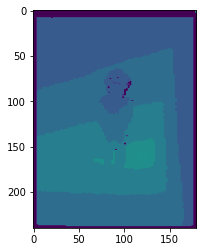

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_230.depth


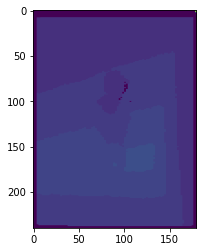

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_240.depth


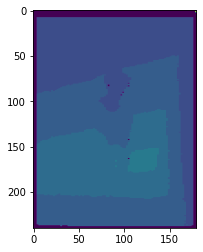

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_250.depth


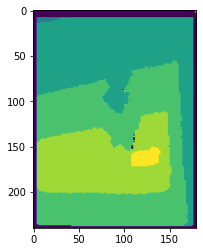

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_260.depth


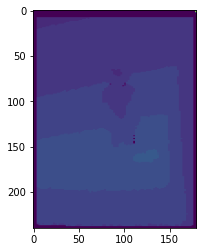

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_270.depth


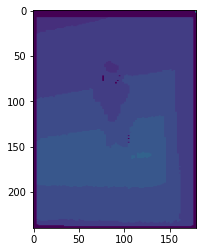

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_280.depth


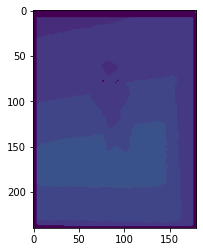

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_290.depth


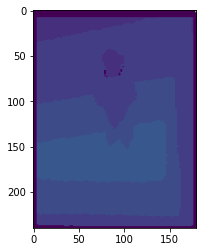

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_100_300.depth


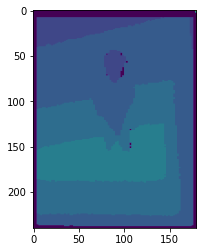

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_650.depth


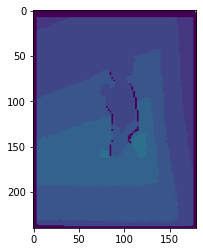

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_660.depth


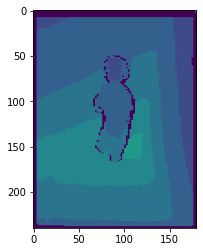

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_670.depth


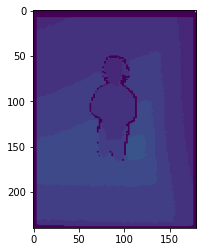

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_680.depth


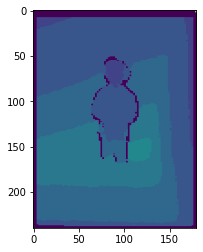

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_690.depth


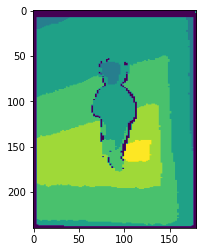

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_700.depth


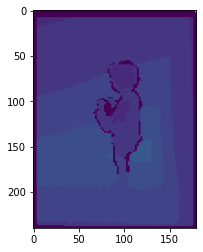

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_710.depth


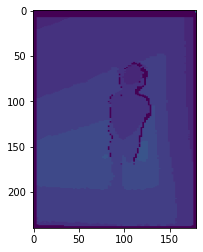

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_720.depth


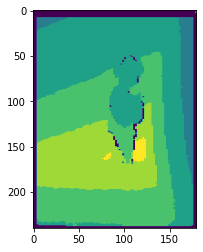

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_730.depth


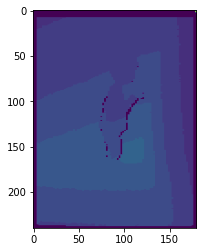

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_740.depth


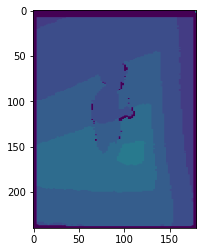

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_101_750.depth


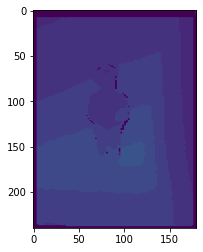

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_490.depth


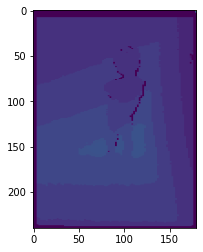

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_500.depth


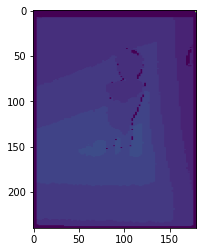

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_510.depth


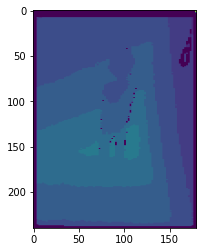

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_520.depth


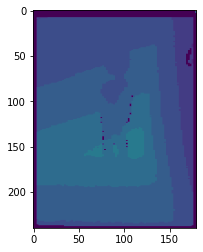

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_530.depth


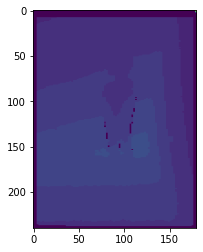

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_540.depth


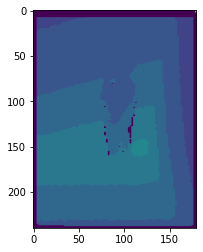

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_550.depth


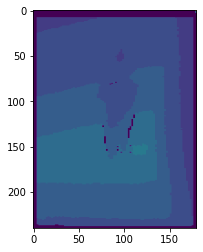

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_560.depth


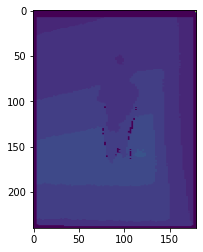

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_570.depth


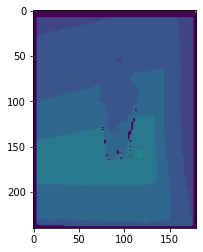

processing file:20200507A-test-mm/measurements/1588839786247/depth/depth_20200507A-test-mm_1588839786247_102_580.depth


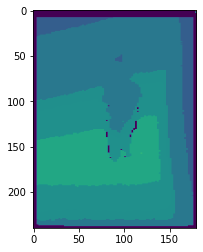

In [204]:
depth_images = []
for depthscan in depthfiles:
    num =0
    with ZipFile(depthscan,'r') as compressed_depth:
        listOfFileNames = compressed_depth.namelist()
        for fileName in listOfFileNames:
            print("processing file:{}".format(depthscan))
            dataf = compressed_depth.extract(fileName, 'temp_csv')
            data, width, height, depthScale = read_data(dataf)
            depthimage,image_height,image_width = prepare_depthmap(data, width, height, depthScale)
            rot_depthimage = np.rot90(depthimage,-1,axes=(0, 1))
            plt.figure(1); plt.clf()
            plt.imshow(rot_depthimage)
            plt.pause(2)
            img = Image.fromarray(rot_depthimage.astype("float32"))
            scaled_img = img.resize((172,224))
    depth_images.append(scaled_img)
    num+=1
#             plt.imshow(image)
    shutil.rmtree('temp_csv')

In [298]:
total_images = []
for numberofimges in range(len(depth_images)):
    addchannel = np.expand_dims(depth_images[numberofimges], axis=2)
    total_images.append(addchannel)
total_images = np.array(total_images)
print("Input shape for the models:",total_images.shape)
scores = model.predict(total_images)
for i in range(len(scores)):
    print('score for {} : {}'.format(depthfiles[i].split('/')[-1],scores[i]))

Input shape for the models: (30, 224, 172, 1)
score for depth_20200507A-test-mm_1588839786247_100_220.depth : [476.40173]
score for depth_20200507A-test-mm_1588839786247_100_230.depth : [333.7387]
score for depth_20200507A-test-mm_1588839786247_100_240.depth : [94.26047]
score for depth_20200507A-test-mm_1588839786247_100_250.depth : [427.4594]
score for depth_20200507A-test-mm_1588839786247_100_260.depth : [542.4147]
score for depth_20200507A-test-mm_1588839786247_100_270.depth : [261.74146]
score for depth_20200507A-test-mm_1588839786247_100_280.depth : [79.67371]
score for depth_20200507A-test-mm_1588839786247_100_290.depth : [73.5252]
score for depth_20200507A-test-mm_1588839786247_100_300.depth : [74.72367]
score for depth_20200507A-test-mm_1588839786247_101_650.depth : [94.26047]
score for depth_20200507A-test-mm_1588839786247_101_660.depth : [94.26047]
score for depth_20200507A-test-mm_1588839786247_101_670.depth : [150.35379]
score for depth_20200507A-test-mm_1588839786247_101_

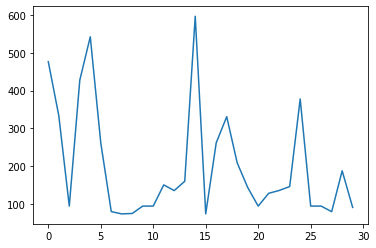

<Figure size 432x288 with 0 Axes>

In [220]:
# plotting the results of models
newdata = np.squeeze(score) 
plt.plot(newdata) # plotting by columns
plt.show()
plt.savefig('initialresults.png')

 ### Convnet_visualisation

In [323]:
# from keras.applications.vgg16 import VGG16
from keras import backend as K
# import tensorflow.keras.backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
# K.clear_session()

In [338]:
def convnet_visualisation(model,layer_name,model_input):
    output = model.output[:, 0]
    # The is the output feature map of the `conv2d_10` layer,
    # the last convolutional layer in Network
    last_conv_layer = model.get_layer(layer_name)
    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `conv2d_10`
    grads = K.gradients(output, last_conv_layer.output)[0]
    # This is a vector of shape (256,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1,2))
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `conv2d_10`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([model_input])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

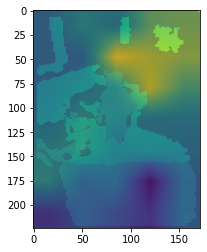

In [588]:
im = plt.imread('depthmap.png')
implot = plt.imshow(im)
plt.imshow(heatmap,alpha=.7)
plt.show()

### checking on anon-depth map on which the model was trained on

In [ ]:
from azureml.core import Workspace, Dataset

subscription_id = '9b82ecea-6780-4b85-8acf-d27d79028f07'
resource_group = 'cgm-ml-prod'
workspace_name = 'cgm-azureml-prod'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='anon-depthmap-npy-test')
dataset.download(target_path='.', overwrite=False)

In [71]:
import pickle
old_depthmap = 'npy/7ll396perp/pcrgb_7ll396perp_1586843918792_104_000.p'
infile = open(old_depthmap,'rb')
sample_depthmap = pickle.load(infile)

(224, 172)


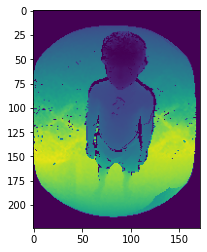

In [93]:
from skimage.io import imsave
sample =  sample_depthmap[0]
imsave('depthmap_anonsample.png',sample)
sample = np.squeeze(sample)
print(sample.shape)
plt.imshow(sample)

In [40]:
test_sample = sample_depthmap[0]
anon_input=  np.expand_dims(test_sample, axis=0)
print(anon_input.shape)
anon_sample_score = model.predict(anon_input)
anon_sample_score

(1, 224, 172, 1)


array([[89.92386]], dtype=float32)

In [ ]:
layer_name = 'conv2d_10'
heatmap = convnet_visualisation(model,layer_name,model_input)
heatmap = cv2.resize(heatmap, (172, 224))
plt.imshow(heatmap)

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
cv2.imwrite('heatmap_anonsample.png',heatmap)

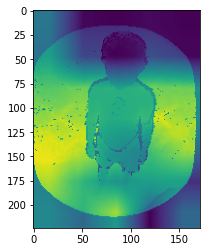

In [105]:
# blending the sample depthmaps and heatmaps to analyse the model prediction location
background_ = Image.open("depthmap_anonsample.png")
foreground = Image.open("heatmap_anonsample.png")
blendedimage = Image.blend(background,foreground, alpha=.5)
plt.imshow(blendedimage)

In [108]:
blendedimage.save('lenovo_vis.png')